Курсовой проект от Александра Иванова. (https://geekbrains.ru/users/2818070)

In [1]:
import warnings
from tqdm import tqdm

import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gmean, rankdata
# from scipy.stats import ttest_rel
import time

import lightgbm as lgb
import re


from sklearn.metrics import r2_score, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
ITER_VER = 8

-----------------------------

In [3]:
# Создадим функции групировки по пользователям и агрегирования значений в датафрейме 
# для последующего присоеднинения к основному ДФ

def agg_numeric(df, parent_var, df_name):
    """
    Группировка и агрегирование числовых признаков датафрейма.
    
    Parameters
    --------
        df (dataframe): 
            датафрейм для преобразования
        parent_var (string): 
            название признака для группировки
        df_name (string): 
            Имя для новых значений признаков
        
    Return
    --------
        agg (dataframe): 
            Датафрейм с новыми агригированными признаками 
    
    """
    
    # Remove id variables other than grouping variable
    for col in df:
        if col != parent_var and 'prev_application_number' in col:
            df = df.drop(columns = col)
            
    # Only want the numeric variables
    parent_ids = df[parent_var].copy()
    numeric_df = df.select_dtypes('number').copy()
    numeric_df[parent_var] = parent_ids

    # Group by the specified variable and calculate the statistics
    agg = numeric_df.groupby(parent_var).agg(['count', 'mean', 'max', 'min', 'sum'])

    # Need to create new column names
    columns = []

    # Iterate through the variables names
    for var in agg.columns.levels[0]:
        if var != parent_var:
            # Iterate through the stat names
            for stat in agg.columns.levels[1]:
                # Make a new column name for the variable and stat
                columns.append('%s_%s_%s' % (df_name, var, stat))
    
    agg.columns = columns
    
    # Remove the columns with all redundant values
    _, idx = np.unique(agg, axis = 1, return_index=True)
    agg = agg.iloc[:, idx]
    
    return agg


def agg_categorical(df, parent_var, df_name):
    """
    Обработка категориальных признаков
    
    Parameters
    --------
    df : dataframe 
        Датафрейм для обработки.
        
    parent_var : string
        Назавние призная для группировки
        
    df_name : string
        Имя для новых признаков

    
    Return
    --------
    categorical : dataframe
        Датафрейм с новыми, обработанными, признаками.
        
    """
    
    # Select the categorical columns
    categorical = pd.get_dummies(df.select_dtypes('object'))

    # Make sure to put the identifying id on the column
    categorical[parent_var] = df[parent_var]

    # Groupby the group var and calculate the sum and mean
    categorical = categorical.groupby(parent_var).agg(['sum', 'count', 'mean'])
    
    column_names = []
    
    # Iterate through the columns in level 0
    for var in categorical.columns.levels[0]:
        # Iterate through the stats in level 1
        for stat in ['sum', 'count', 'mean']:
            # Make a new column name
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    # Remove duplicate columns by values
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [4]:
def get_input(data_path: str) -> pd.DataFrame:
    """
    Считывание данных и вывод основной информации о наборе данных.

    Parameters
    ----------
    data_path: str
        Название файла.

    Returns
    -------
    data: pandas.core.frame.DataFrame
        Загруженный набор данных в pandas.DataFrame

    """
    base_path = "data_input"
    data = pd.read_csv(f"{base_path}/{data_path}")
    data.columns = [col.lower() for col in data.columns]
    print(f"{data_path}: shape = {data.shape[0]} rows, {data.shape[1]} cols")

    return data

In [5]:
# Функция графика зависимости признака от целевой переменной
def kde_target_plot(df, feature):
    """
    Функцияраспределения целевой переменной от заданной
    Parameters
    ----------
    df : dataframe 
        Датафрейм
        
    feature : string
        Имя признака

    """
    
    # Need to reset index for loc to workBU
    df = df.reset_index()
    plt.figure(figsize = (9, 4))
    plt.style.use('fivethirtyeight')
    
    # plot repaid loans
    sns.kdeplot(df.loc[df['target'] == 0, feature], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(df.loc[df['target'] == 1, feature], label = 'target == 1')
    
    # Label the plots
    plt.legend()
    plt.title('Распределение признака от Таргета')
    plt.xlabel('%s' % feature); plt.ylabel('Density');

In [6]:
def create_dummy_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание One-Hot-Enconding признаков для категориальных
    переменных. Признаки создаются на основе объединенных
    train и test выборок, чтобы исключить потенциальные
    конфликты с отсутствием редких значений в одной
    из выборок.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.XFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()
        
#     categorical = X.select_dtypes('category').columns
    categorical = X.select_dtypes('object').columns
    

    X = pd.get_dummies(
        X, prefix=categorical, dummy_na=True
    )
    
    return X

### EDA

In [7]:
def create_client_profile_features(X: pd.DataFrame, copy: bool = True) -> pd.DataFrame:
    """
    Создание признаков на основе профиля клиентов.

    Parameters
    ----------
    X: pandas.core.frame.DataFrame
        Матрица признаков с исходным профилем клиента.

    copy: bool, optional, default = True
        Флаг использования копии датафрейма X.
        Опциональный параметр, по умолчанию, равен True.

    Returns
    -------
    X_transformed: pandas.core.frame.DataFrame
        Расширенная матрица признаков с профилем клиентов.

    """
    if copy:
        X = X.copy()

    
    X['age'] = (X['age'] / 365)
    X["days_on_last_job"] = X["days_on_last_job"].replace(365243, np.nan)
    bki_flags = [flag for flag in X.columns if "amt_req_credit_bureau" in flag]
    X["bki_requests_count"] = X[bki_flags].sum(axis=1)
    X["bki_kurtosis"] = X[bki_flags].kurtosis(axis=1)

    X["external_scoring_prod"] = X["external_scoring_rating_1"] * X["external_scoring_rating_2"] * X["external_scoring_rating_3"]
    X["external_scoring_weighted"] = X.external_scoring_rating_1 * 2 + X.external_scoring_rating_2 * 1 + X.external_scoring_rating_3 * 3

    for function_name in ["min", "max", "mean", "nanmedian", "var"]:
        feature_name = "external_scoring_rating_{}".format(function_name)
        X[feature_name] = eval("np.{}".format(function_name))(
            X[["external_scoring_rating_1", "external_scoring_rating_2", "external_scoring_rating_3"]], axis=1
        )

    # Отношение между основными фин. показателями
    X['ratio_credit_to_annuity'] = X['amount_credit'] / X['amount_annuity']
    X["ratio_annuity_to_salary"] = X['amount_annuity'] / X['total_salary']
    X['ratio_credit_to_salary'] = X['amount_credit'] / X['total_salary']
    #X["total_salary_net"] = X["total_salary"] - X["amount_annuity"]

    # Отношение фин. показателей к возрасту и временным фичам
    X["ratio_annuity_to_age"] = X["amount_annuity"] / (X["age"] * 1000)
    X["ratio_credit_to_age"] = X["amount_credit"] / (X["age"] * 1000)
    X["ratio_salary_to_age"] = X["total_salary"] / (X["age"] * 1000)
    X["ratio_salary_to_experience"] = X["total_salary"] / X["days_on_last_job"]
    X["ratio_credit_to_experience"] = X["amount_credit"] / X["days_on_last_job"]
    X["ratio_annuity_to_experience"] = X["amount_annuity"] / X["days_on_last_job"]

    # Отношение врменных признаков
    X["ratio_age_to_experience"] = (X["age"] * 365) / X["days_on_last_job"]
    X["ratio_salary_to_region_population"] = X["total_salary"] * X["region_population"]
    X["ratio_car_to_experience"] = X["own_car_age"] / X["days_on_last_job"]
    X["ratio_car_to_age"] = X["own_car_age"] / X["age"]

    # Произведение фин. показателей кредита на вероятность дефолта
    # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
    X["expected_total_loss_1"] = X["external_scoring_rating_1"] * X["amount_credit"]
    X["expected_total_loss_2"] = X["external_scoring_rating_2"] * X["amount_credit"]
    X["expected_total_loss_3"] = X["external_scoring_rating_3"] * X["amount_credit"]
    X["expected_monthly_loss_1"] = X["external_scoring_rating_1"] * X["amount_annuity"]
    X["expected_monthly_loss_2"] = X["external_scoring_rating_2"] * X["amount_annuity"]
    X["expected_monthly_loss_3"] = X["external_scoring_rating_3"] * X["amount_annuity"]
    
    
#     Обработаем катерогию "Age", создадим бины
    bins = np.linspace(18, 70, 6)
    X['age_bins'] = np.digitize(X['age'], bins)
    X.loc[X['age'].isnull(), 'age_bins'] = np.NaN
    X['age_bins'] = X['age_bins'].astype('object')
    
#     Создадим категориальный признак на основе "family_size"
    X['family_size_bin'] = np.NaN
    X.loc[X['family_size'] == 1, 'family_size_bin'] = 1
    X.loc[X['family_size'] == 2, 'family_size_bin'] = 2
    X.loc[X['family_size'] == 3, 'family_size_bin'] = 3
    X.loc[(X['family_size'] > 3), 'family_size_bin'] = 4
    X['family_size_bin'] = X['family_size_bin'].astype('object')
    
#     *********************************
#     Создадим бинарный признак на основе признака "external_scoring_prod" 
    X['external_scoring_prod_bin'] = np.NaN
    X.loc[X['external_scoring_prod'] > 0.1, 'external_scoring_prod_bin'] = 0
    X.loc[X['external_scoring_prod'] <= 0.1, 'external_scoring_prod_bin'] = 1
    
#     Заменим неопределенные значения при делении на 0 на НаН
    X = X.replace(np.inf, np.nan)
    X = X.replace(-np.inf, np.nan)

    return X

-----------------------------

In [8]:
# Загрузим наборы данных трейн и теста
train = get_input("train.csv")
test = get_input("test.csv")

# Объеденим их в один фрейм данных для правильной обработки категориальных признаков
data = pd.concat([train, test], axis=0)
data = data.reset_index(drop=True)

train.csv: shape = 110093 rows, 3 cols
test.csv: shape = 165141 rows, 2 cols


In [9]:
# Загрузим фрейм профайлов клиентов
client_profile = get_input("client_profile.csv")

# Агрегируем и обработаем признаки. Построим новые
client_profile = create_client_profile_features(client_profile)
client_profile.head(n=2)

client_profile.csv: shape = 250000 rows, 24 cols


,application_number,gender,childrens,total_salary,amount_credit,amount_annuity,education_level,family_status,region_population,age,...,ratio_car_to_age,expected_total_loss_1,expected_total_loss_2,expected_total_loss_3,expected_monthly_loss_1,expected_monthly_loss_2,expected_monthly_loss_3,age_bins,family_size_bin,external_scoring_prod_bin
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,23.452055,...,NaN,88957.124333,63804.966560,183213.275945,4447.856217,3190.248328,9160.663797,1.0,2.0,1.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,63.526027,...,NaN,NaN,237475.743779,431008.094056,NaN,12590.802122,22851.755462,5.0,2.0,NaN


In [10]:
# Объеденим фреймы по заемщикамй
data = data.merge(
    client_profile, how="left", on="application_number"
)

In [11]:
# Загрузим датасет с данными кредитного бюро
bki = get_input("bki.csv")
bki.head(2)

bki.csv: shape = 945234 rows, 17 cols


,application_number,bureau_id,credit_active,credit_currency,days_credit,credit_day_overdue,days_credit_enddate,days_enddate_fact,amt_credit_max_overdue,cnt_credit_prolong,amt_credit_sum,amt_credit_sum_debt,amt_credit_sum_limit,amt_credit_sum_overdue,credit_type,days_credit_update,amt_annuity
0,123538884,5223613,Active,currency 1,718.0,0,377.0,NaN,19386.81,0,675000.00,320265.495,0.0,0.0,Consumer credit,39.0,NaN
1,123436670,6207544,Closed,currency 1,696.0,0,511.0,511.0,0.00,0,93111.66,0.000,0.0,0.0,Consumer credit,505.0,NaN


In [12]:
# Аггрегатируем кол-во предыдущих кредитов по заемщику
previous_loan_counts =  bki.groupby('application_number', as_index=False)['bureau_id'].count().\
    rename(columns = {'bureau_id': 'PREV_LOAN_counts'})
previous_loan_counts.head(2)

,application_number,PREV_LOAN_counts
0,123423340,2
1,123423341,5


In [13]:
# Соеденим признак с основным датасетом
data = data.merge(
    previous_loan_counts, how="left", on="application_number"
)

In [14]:
bki_credit_active = agg_categorical(bki[['application_number', 'credit_active']], 'application_number', 'bki' )

In [15]:
# Соеденим признак с основным датасетом
data = data.merge(
    bki_credit_active, how="left", on="application_number"
)

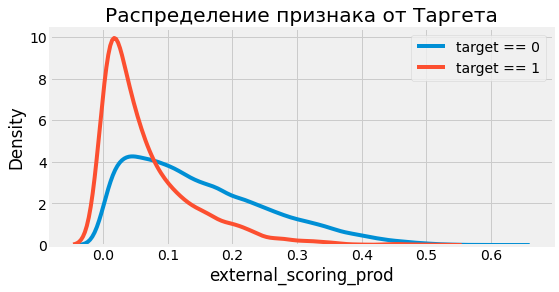

In [16]:
# Признак имеет мах плотность в пределах до 0.1. Имеет смысл ввести бинарный признак этого значения 1 - интервал от 0 до 0.1 
# и 0 выше 0.1
kde_target_plot(data, 'external_scoring_prod')

In [17]:
# категориальный признак на основе "family_size"
data['family_size'].value_counts()
# Видим, что после 7 кол-во значений совсем незначительное по отношению ко всей выборке

2.0     115137
1.0      49227
3.0      38350
4.0      18061
5.0       2545
6.0        303
7.0         61
8.0         14
9.0          5
10.0         3
16.0         2
15.0         1
20.0         1
13.0         1
11.0         1
14.0         1
Name: family_size, dtype: int64

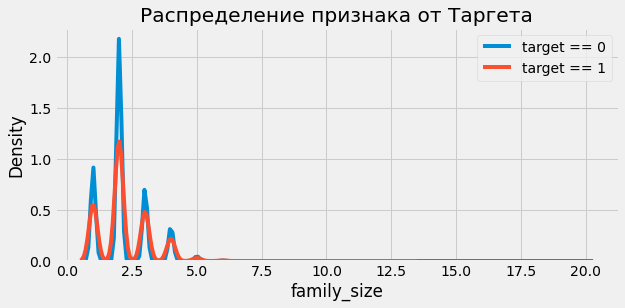

In [18]:
# Посомтрим распределение "family_size" к таргету
kde_target_plot(data, 'family_size')
# Создадим rатегоиальный признак на 4 бина по кол-ву членов семьи. Все занчения больше 4 отнесем в четвертую группу

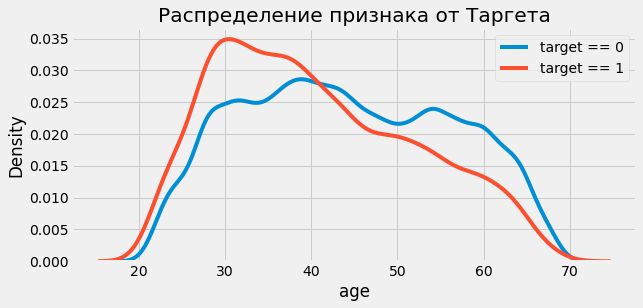

In [19]:
# Обработаем катерогию "Age", создадим бины
# Посомтрим распределение "family_size" к таргету
kde_target_plot(data, 'age')
# Видим, что плотность рисковых заемщиком падает по мере увеличения возраста.
# Имеет смысл создать категориальный признак по позрастным группам.
# Создадим 6 бинов ( в последний бин попадут все значения НаН)

In [20]:
# Обработаем категориальные пересенные методом get_dummies()
data = create_dummy_features(data)

In [21]:
# Маска для разделения теста и трейн наборов,
mask = data["target"].isnull()
features_to_drop = ["application_number", "target"]

train, test = data.loc[~mask], data.loc[mask]

target, test_id = train["target"], test["application_number"]
train = train.drop(features_to_drop, axis=1)
test = test.drop(features_to_drop, axis=1)

categorial = train.dtypes[train.dtypes == "object"].index
numerical = list(set(train.columns) - set(categorial))

In [22]:
# Создадим пустой датафрейм предсказаний
submission = pd.DataFrame(test_id, columns=['application_number'])

In [23]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=5000,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

In [24]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    folds_scores = []
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)
        
    print(f"Score by each fold: {folds_scores}")
    print("="*65)

    return estimators, encoders, oof_preds

In [25]:
def catboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = cb.CatBoostClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            verbose=50, early_stopping_rounds=5000
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds

### LightGBM

In [42]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 12000,
    'learning_rate': 0.004834,
    'num_leaves': 45,
    'max_depth': 9,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

# Создадим Kfold=7, разделим трейн на Тагрет и данные
cv = KFold(n_splits=7, random_state=435, shuffle=True)

In [43]:
# Получим модели и ООФ прогнозы ка Kfold=7 для ЛайтДЖИБИЭМ
estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, train, target, cv
)

Wed Dec 23 18:12:44 2020, Cross-Validation, 110093 rows, 81 cols
Training until validation scores don't improve for 5000 rounds
[50]	valid_0's auc: 0.720529	valid_0's binary_logloss: 0.27108
[100]	valid_0's auc: 0.723955	valid_0's binary_logloss: 0.265218
[150]	valid_0's auc: 0.726105	valid_0's binary_logloss: 0.261414
[200]	valid_0's auc: 0.727396	valid_0's binary_logloss: 0.258773
[250]	valid_0's auc: 0.729354	valid_0's binary_logloss: 0.256841
[300]	valid_0's auc: 0.731255	valid_0's binary_logloss: 0.255396
[350]	valid_0's auc: 0.732396	valid_0's binary_logloss: 0.254275
[400]	valid_0's auc: 0.732964	valid_0's binary_logloss: 0.253459
[450]	valid_0's auc: 0.734087	valid_0's binary_logloss: 0.252689
[500]	valid_0's auc: 0.734907	valid_0's binary_logloss: 0.252163
[550]	valid_0's auc: 0.736546	valid_0's binary_logloss: 0.251616
[600]	valid_0's auc: 0.738351	valid_0's binary_logloss: 0.251087
[650]	valid_0's auc: 0.739523	valid_0's binary_logloss: 0.250669
[700]	valid_0's auc: 0.740432

[6200]	valid_0's auc: 0.738827	valid_0's binary_logloss: 0.250269
[6250]	valid_0's auc: 0.738862	valid_0's binary_logloss: 0.250277
[6300]	valid_0's auc: 0.738805	valid_0's binary_logloss: 0.25029
[6350]	valid_0's auc: 0.738578	valid_0's binary_logloss: 0.25031
[6400]	valid_0's auc: 0.738679	valid_0's binary_logloss: 0.250316
[6450]	valid_0's auc: 0.738624	valid_0's binary_logloss: 0.250353
[6500]	valid_0's auc: 0.738509	valid_0's binary_logloss: 0.250377
[6550]	valid_0's auc: 0.738497	valid_0's binary_logloss: 0.250403
[6600]	valid_0's auc: 0.738406	valid_0's binary_logloss: 0.25042
[6650]	valid_0's auc: 0.738455	valid_0's binary_logloss: 0.250452
[6700]	valid_0's auc: 0.738413	valid_0's binary_logloss: 0.25048
[6750]	valid_0's auc: 0.738324	valid_0's binary_logloss: 0.250514
[6800]	valid_0's auc: 0.73806	valid_0's binary_logloss: 0.250542
[6850]	valid_0's auc: 0.738067	valid_0's binary_logloss: 0.250572
Early stopping, best iteration is:
[1871]	valid_0's auc: 0.743341	valid_0's binar

[5450]	valid_0's auc: 0.7425	valid_0's binary_logloss: 0.251428
[5500]	valid_0's auc: 0.742489	valid_0's binary_logloss: 0.251452
[5550]	valid_0's auc: 0.742473	valid_0's binary_logloss: 0.251489
[5600]	valid_0's auc: 0.742457	valid_0's binary_logloss: 0.251525
[5650]	valid_0's auc: 0.742316	valid_0's binary_logloss: 0.251548
[5700]	valid_0's auc: 0.742164	valid_0's binary_logloss: 0.251584
[5750]	valid_0's auc: 0.742199	valid_0's binary_logloss: 0.251586
[5800]	valid_0's auc: 0.742212	valid_0's binary_logloss: 0.251595
[5850]	valid_0's auc: 0.742258	valid_0's binary_logloss: 0.251602
[5900]	valid_0's auc: 0.742213	valid_0's binary_logloss: 0.251612
[5950]	valid_0's auc: 0.742267	valid_0's binary_logloss: 0.251629
[6000]	valid_0's auc: 0.742289	valid_0's binary_logloss: 0.251653
[6050]	valid_0's auc: 0.742353	valid_0's binary_logloss: 0.251658
[6100]	valid_0's auc: 0.742435	valid_0's binary_logloss: 0.251663
[6150]	valid_0's auc: 0.742413	valid_0's binary_logloss: 0.251673
[6200]	valid

[3800]	valid_0's auc: 0.732006	valid_0's binary_logloss: 0.258613
[3850]	valid_0's auc: 0.732013	valid_0's binary_logloss: 0.258644
[3900]	valid_0's auc: 0.732101	valid_0's binary_logloss: 0.258656
[3950]	valid_0's auc: 0.732042	valid_0's binary_logloss: 0.258694
[4000]	valid_0's auc: 0.731964	valid_0's binary_logloss: 0.25872
[4050]	valid_0's auc: 0.731941	valid_0's binary_logloss: 0.258713
[4100]	valid_0's auc: 0.732057	valid_0's binary_logloss: 0.258739
[4150]	valid_0's auc: 0.732182	valid_0's binary_logloss: 0.258737
[4200]	valid_0's auc: 0.732217	valid_0's binary_logloss: 0.258768
[4250]	valid_0's auc: 0.732127	valid_0's binary_logloss: 0.258799
[4300]	valid_0's auc: 0.732156	valid_0's binary_logloss: 0.258831
[4350]	valid_0's auc: 0.732166	valid_0's binary_logloss: 0.258857
[4400]	valid_0's auc: 0.732083	valid_0's binary_logloss: 0.258908
[4450]	valid_0's auc: 0.732101	valid_0's binary_logloss: 0.258964
[4500]	valid_0's auc: 0.73197	valid_0's binary_logloss: 0.258978
[4550]	valid

[3600]	valid_0's auc: 0.719231	valid_0's binary_logloss: 0.254368
[3650]	valid_0's auc: 0.719057	valid_0's binary_logloss: 0.254377
[3700]	valid_0's auc: 0.718996	valid_0's binary_logloss: 0.254406
[3750]	valid_0's auc: 0.719009	valid_0's binary_logloss: 0.254437
[3800]	valid_0's auc: 0.718777	valid_0's binary_logloss: 0.254473
[3850]	valid_0's auc: 0.718547	valid_0's binary_logloss: 0.254521
[3900]	valid_0's auc: 0.718534	valid_0's binary_logloss: 0.254549
[3950]	valid_0's auc: 0.718544	valid_0's binary_logloss: 0.254566
[4000]	valid_0's auc: 0.718556	valid_0's binary_logloss: 0.254602
[4050]	valid_0's auc: 0.718471	valid_0's binary_logloss: 0.254647
[4100]	valid_0's auc: 0.718409	valid_0's binary_logloss: 0.254656
[4150]	valid_0's auc: 0.718348	valid_0's binary_logloss: 0.254673
[4200]	valid_0's auc: 0.718405	valid_0's binary_logloss: 0.254694
[4250]	valid_0's auc: 0.718464	valid_0's binary_logloss: 0.254719
[4300]	valid_0's auc: 0.718483	valid_0's binary_logloss: 0.254749
[4350]	val

[2850]	valid_0's auc: 0.724384	valid_0's binary_logloss: 0.254875
[2900]	valid_0's auc: 0.724391	valid_0's binary_logloss: 0.254886
[2950]	valid_0's auc: 0.72432	valid_0's binary_logloss: 0.254909
[3000]	valid_0's auc: 0.724408	valid_0's binary_logloss: 0.254928
[3050]	valid_0's auc: 0.724469	valid_0's binary_logloss: 0.254948
[3100]	valid_0's auc: 0.724333	valid_0's binary_logloss: 0.254961
[3150]	valid_0's auc: 0.724459	valid_0's binary_logloss: 0.254958
[3200]	valid_0's auc: 0.72441	valid_0's binary_logloss: 0.254969
[3250]	valid_0's auc: 0.724247	valid_0's binary_logloss: 0.25499
[3300]	valid_0's auc: 0.724334	valid_0's binary_logloss: 0.254999
[3350]	valid_0's auc: 0.724379	valid_0's binary_logloss: 0.25499
[3400]	valid_0's auc: 0.724363	valid_0's binary_logloss: 0.255009
[3450]	valid_0's auc: 0.724252	valid_0's binary_logloss: 0.255043
[3500]	valid_0's auc: 0.724239	valid_0's binary_logloss: 0.255046
[3550]	valid_0's auc: 0.724301	valid_0's binary_logloss: 0.255049
[3600]	valid_0

[2850]	valid_0's auc: 0.717787	valid_0's binary_logloss: 0.25663
[2900]	valid_0's auc: 0.717686	valid_0's binary_logloss: 0.256642
[2950]	valid_0's auc: 0.717667	valid_0's binary_logloss: 0.256648
[3000]	valid_0's auc: 0.71775	valid_0's binary_logloss: 0.256658
[3050]	valid_0's auc: 0.717727	valid_0's binary_logloss: 0.256655
[3100]	valid_0's auc: 0.71784	valid_0's binary_logloss: 0.256677
[3150]	valid_0's auc: 0.71781	valid_0's binary_logloss: 0.256676
[3200]	valid_0's auc: 0.717945	valid_0's binary_logloss: 0.256684
[3250]	valid_0's auc: 0.717927	valid_0's binary_logloss: 0.256692
[3300]	valid_0's auc: 0.717883	valid_0's binary_logloss: 0.256735
[3350]	valid_0's auc: 0.717665	valid_0's binary_logloss: 0.256781
[3400]	valid_0's auc: 0.717771	valid_0's binary_logloss: 0.2568
[3450]	valid_0's auc: 0.717583	valid_0's binary_logloss: 0.256836
[3500]	valid_0's auc: 0.717498	valid_0's binary_logloss: 0.25687
[3550]	valid_0's auc: 0.717287	valid_0's binary_logloss: 0.256922
[3600]	valid_0's 

[2300]	valid_0's auc: 0.724829	valid_0's binary_logloss: 0.247384
[2350]	valid_0's auc: 0.724867	valid_0's binary_logloss: 0.24738
[2400]	valid_0's auc: 0.724681	valid_0's binary_logloss: 0.24739
[2450]	valid_0's auc: 0.724493	valid_0's binary_logloss: 0.2474
[2500]	valid_0's auc: 0.724368	valid_0's binary_logloss: 0.247385
[2550]	valid_0's auc: 0.724707	valid_0's binary_logloss: 0.247395
[2600]	valid_0's auc: 0.724431	valid_0's binary_logloss: 0.247431
[2650]	valid_0's auc: 0.724242	valid_0's binary_logloss: 0.247426
[2700]	valid_0's auc: 0.724265	valid_0's binary_logloss: 0.247435
[2750]	valid_0's auc: 0.724148	valid_0's binary_logloss: 0.247436
[2800]	valid_0's auc: 0.724049	valid_0's binary_logloss: 0.247444
[2850]	valid_0's auc: 0.724539	valid_0's binary_logloss: 0.247445
[2900]	valid_0's auc: 0.724726	valid_0's binary_logloss: 0.247454
[2950]	valid_0's auc: 0.724622	valid_0's binary_logloss: 0.247441
[3000]	valid_0's auc: 0.724319	valid_0's binary_logloss: 0.247478
[3050]	valid_0

In [ ]:
# Score by each fold: [0.74269, 0.74332, 0.73279, 0.72105, 0.72616, 0.71877, 0.72616]

<b>Score by each fold: [0.74339, 0.74385, 0.73353, 0.71932, 0.72684, 0.7182, 0.72515]

### XGboost

In [51]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "n_estimators": 12000,
    "eta": 0.05,
    "max_depth": 8,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 35,
    "alpha": 0.01,
    "lambda": 10,
    "nthread": -1,
    "random_seed": 27
}

xgb_cv = KFold(n_splits=7, random_state=42, shuffle=True)

In [52]:
# Получим модели и ООФ прогнозы ка Kfold=7 для ИКСДЖИБУСТ
estimators_xgb, _, oof_preds_xgb = xgboost_cross_validation(
    xgb_params, train, target, xgb_cv
)

Wed Dec 23 18:22:28 2020, Cross-Validation, 110093 rows, 81 cols
[18:22:29] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators, random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.66041	valid-auc:0.67380
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.69195	valid-auc:0.70683
[20]	train-auc:0.70160	valid-auc:0.71495
[30]	train-auc:0.70920	valid-auc:0.72042
[40]	train-auc:0.71430	valid-auc:0.72428
[50]	train-auc:0.71920	valid-auc:0.72757
[60]	train-auc:0.72443	valid-auc:0.72967
[70]	train-auc:0.72936	valid-auc:0.73284
[80]	train-auc:0.73362	valid-auc:0.73536
[90]	train-auc:0.7371

Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.69610	valid-auc:0.69077
[20]	train-auc:0.70356	valid-auc:0.69927
[30]	train-auc:0.71040	valid-auc:0.70251
[40]	train-auc:0.71588	valid-auc:0.70490
[50]	train-auc:0.72022	valid-auc:0.70858
[60]	train-auc:0.72619	valid-auc:0.71252
[70]	train-auc:0.73139	valid-auc:0.71605
[80]	train-auc:0.73552	valid-auc:0.71885
[90]	train-auc:0.73906	valid-auc:0.72190
[100]	train-auc:0.74152	valid-auc:0.72331
[110]	train-auc:0.74421	valid-auc:0.72454
[120]	train-auc:0.74669	valid-auc:0.72579
[130]	train-auc:0.74879	valid-auc:0.72642
[140]	train-auc:0.74989	valid-auc:0.72639
[150]	train-auc:0.75100	valid-auc:0.72720
[160]	train-auc:0.75258	valid-auc:0.72744
[170]	train-auc:0.75355	valid-auc:0.72808
[180]	train-auc:0.75447	valid-auc:0.72859
[190]	train-auc:0.75501	valid-auc:0.72859
[200]	train-auc:0.75605	valid-auc:0.72855
[210]	train-auc:0.75681	va

In [ ]:
# Score by each fold: [0.74282, 0.73002, 0.72254, 0.73683, 0.73052, 0.71907, 0.72351]

<b>Score by each fold: [0.74105, 0.73251, 0.72121, 0.73629, 0.72806, 0.72084, 0.72303]

### CatBoost

In [74]:
cb_params = {
    "n_estimators": 9000,
    "loss_function": "Logloss",
    "eval_metric": "AUC",
    "task_type": "CPU",
    "max_bin": 38,
    "verbose": 10,
    "max_depth": 6,
    "l2_leaf_reg": 120,
    "early_stopping_rounds": 50,
    "thread_count": -1,
    "random_seed": 27
}

# Создадим Kfold=7 стратегию валидации
cat_cv = KFold(n_splits=7, random_state=32, shuffle=True)

In [75]:
# Получим ООФ прогнозы и модели для КатБуст
estimators_cat, oof_preds_cat = catboost_cross_validation(
    cb_params, train, target, cat_cv
)

Wed Dec 23 18:55:44 2020, Cross-Validation, 110093 rows, 81 cols
0:	test: 0.6610747	best: 0.6610747 (0)	total: 27.2ms	remaining: 4m 4s
50:	test: 0.6969773	best: 0.6969773 (50)	total: 1.26s	remaining: 3m 41s
100:	test: 0.7040175	best: 0.7040175 (100)	total: 2.5s	remaining: 3m 39s
150:	test: 0.7081298	best: 0.7081298 (150)	total: 3.7s	remaining: 3m 36s
200:	test: 0.7104043	best: 0.7104043 (200)	total: 4.88s	remaining: 3m 33s
250:	test: 0.7112128	best: 0.7113562 (230)	total: 6.05s	remaining: 3m 30s
300:	test: 0.7117140	best: 0.7117955 (292)	total: 7.23s	remaining: 3m 28s
350:	test: 0.7122141	best: 0.7122560 (346)	total: 8.38s	remaining: 3m 26s
400:	test: 0.7133329	best: 0.7133414 (399)	total: 9.54s	remaining: 3m 24s
450:	test: 0.7136066	best: 0.7136151 (416)	total: 10.6s	remaining: 3m 21s
500:	test: 0.7139281	best: 0.7139301 (499)	total: 11.8s	remaining: 3m 19s
550:	test: 0.7140356	best: 0.7142208 (523)	total: 12.8s	remaining: 3m 17s
600:	test: 0.7141876	best: 0.7142208 (523)	total: 13.9s

5450:	test: 0.7094002	best: 0.7144080 (620)	total: 2m 5s	remaining: 1m 21s
5500:	test: 0.7091036	best: 0.7144080 (620)	total: 2m 6s	remaining: 1m 20s
5550:	test: 0.7091967	best: 0.7144080 (620)	total: 2m 7s	remaining: 1m 19s
5600:	test: 0.7090568	best: 0.7144080 (620)	total: 2m 8s	remaining: 1m 18s
Stopped by overfitting detector  (5000 iterations wait)

bestTest = 0.714408032
bestIteration = 620

Shrink model to first 621 iterations.
Fold 1, Valid score = 0.71441
0:	test: 0.6017947	best: 0.6017947 (0)	total: 22.5ms	remaining: 3m 22s
50:	test: 0.7152639	best: 0.7161438 (42)	total: 1.19s	remaining: 3m 28s
100:	test: 0.7219293	best: 0.7220365 (97)	total: 2.4s	remaining: 3m 31s
150:	test: 0.7267021	best: 0.7267021 (150)	total: 3.62s	remaining: 3m 32s
200:	test: 0.7294802	best: 0.7294802 (200)	total: 4.86s	remaining: 3m 32s
250:	test: 0.7316422	best: 0.7316536 (249)	total: 6.04s	remaining: 3m 30s
300:	test: 0.7324919	best: 0.7324919 (300)	total: 7.2s	remaining: 3m 28s
350:	test: 0.7333120	

5150:	test: 0.7342599	best: 0.7366929 (1355)	total: 1m 52s	remaining: 1m 24s
5200:	test: 0.7341304	best: 0.7366929 (1355)	total: 1m 54s	remaining: 1m 23s
5250:	test: 0.7343337	best: 0.7366929 (1355)	total: 1m 55s	remaining: 1m 22s
5300:	test: 0.7342847	best: 0.7366929 (1355)	total: 1m 56s	remaining: 1m 21s
5350:	test: 0.7343854	best: 0.7366929 (1355)	total: 1m 57s	remaining: 1m 20s
5400:	test: 0.7344230	best: 0.7366929 (1355)	total: 1m 58s	remaining: 1m 19s
5450:	test: 0.7343885	best: 0.7366929 (1355)	total: 1m 59s	remaining: 1m 17s
5500:	test: 0.7341522	best: 0.7366929 (1355)	total: 2m	remaining: 1m 16s
5550:	test: 0.7340136	best: 0.7366929 (1355)	total: 2m 1s	remaining: 1m 15s
5600:	test: 0.7341309	best: 0.7366929 (1355)	total: 2m 3s	remaining: 1m 14s
5650:	test: 0.7339739	best: 0.7366929 (1355)	total: 2m 4s	remaining: 1m 13s
5700:	test: 0.7339975	best: 0.7366929 (1355)	total: 2m 5s	remaining: 1m 12s
5750:	test: 0.7339739	best: 0.7366929 (1355)	total: 2m 6s	remaining: 1m 11s
5800:	te

4150:	test: 0.7147361	best: 0.7207282 (463)	total: 1m 35s	remaining: 1m 51s
4200:	test: 0.7146433	best: 0.7207282 (463)	total: 1m 36s	remaining: 1m 50s
4250:	test: 0.7145437	best: 0.7207282 (463)	total: 1m 37s	remaining: 1m 49s
4300:	test: 0.7145200	best: 0.7207282 (463)	total: 1m 38s	remaining: 1m 47s
4350:	test: 0.7145231	best: 0.7207282 (463)	total: 1m 39s	remaining: 1m 46s
4400:	test: 0.7144194	best: 0.7207282 (463)	total: 1m 41s	remaining: 1m 45s
4450:	test: 0.7145590	best: 0.7207282 (463)	total: 1m 42s	remaining: 1m 44s
4500:	test: 0.7143899	best: 0.7207282 (463)	total: 1m 43s	remaining: 1m 43s
4550:	test: 0.7144098	best: 0.7207282 (463)	total: 1m 44s	remaining: 1m 42s
4600:	test: 0.7142680	best: 0.7207282 (463)	total: 1m 45s	remaining: 1m 41s
4650:	test: 0.7142874	best: 0.7207282 (463)	total: 1m 46s	remaining: 1m 39s
4700:	test: 0.7143897	best: 0.7207282 (463)	total: 1m 48s	remaining: 1m 38s
4750:	test: 0.7143675	best: 0.7207282 (463)	total: 1m 49s	remaining: 1m 37s
4800:	test: 

4050:	test: 0.7340370	best: 0.7404237 (537)	total: 1m 35s	remaining: 1m 56s
4100:	test: 0.7340105	best: 0.7404237 (537)	total: 1m 36s	remaining: 1m 55s
4150:	test: 0.7338009	best: 0.7404237 (537)	total: 1m 37s	remaining: 1m 54s
4200:	test: 0.7336055	best: 0.7404237 (537)	total: 1m 38s	remaining: 1m 52s
4250:	test: 0.7337203	best: 0.7404237 (537)	total: 1m 39s	remaining: 1m 51s
4300:	test: 0.7334554	best: 0.7404237 (537)	total: 1m 41s	remaining: 1m 50s
4350:	test: 0.7334729	best: 0.7404237 (537)	total: 1m 42s	remaining: 1m 49s
4400:	test: 0.7331225	best: 0.7404237 (537)	total: 1m 43s	remaining: 1m 48s
4450:	test: 0.7329765	best: 0.7404237 (537)	total: 1m 44s	remaining: 1m 46s
4500:	test: 0.7328888	best: 0.7404237 (537)	total: 1m 45s	remaining: 1m 45s
4550:	test: 0.7327508	best: 0.7404237 (537)	total: 1m 46s	remaining: 1m 44s
4600:	test: 0.7327246	best: 0.7404237 (537)	total: 1m 48s	remaining: 1m 43s
4650:	test: 0.7325840	best: 0.7404237 (537)	total: 1m 49s	remaining: 1m 42s
4700:	test: 

3900:	test: 0.7165073	best: 0.7214217 (797)	total: 1m 33s	remaining: 2m 2s
3950:	test: 0.7165503	best: 0.7214217 (797)	total: 1m 34s	remaining: 2m 1s
4000:	test: 0.7165169	best: 0.7214217 (797)	total: 1m 36s	remaining: 1m 59s
4050:	test: 0.7162375	best: 0.7214217 (797)	total: 1m 37s	remaining: 1m 58s
4100:	test: 0.7163653	best: 0.7214217 (797)	total: 1m 38s	remaining: 1m 57s
4150:	test: 0.7163634	best: 0.7214217 (797)	total: 1m 39s	remaining: 1m 56s
4200:	test: 0.7162224	best: 0.7214217 (797)	total: 1m 40s	remaining: 1m 55s
4250:	test: 0.7161727	best: 0.7214217 (797)	total: 1m 42s	remaining: 1m 53s
4300:	test: 0.7161026	best: 0.7214217 (797)	total: 1m 43s	remaining: 1m 52s
4350:	test: 0.7161757	best: 0.7214217 (797)	total: 1m 44s	remaining: 1m 51s
4400:	test: 0.7160396	best: 0.7214217 (797)	total: 1m 45s	remaining: 1m 50s
4450:	test: 0.7159766	best: 0.7214217 (797)	total: 1m 46s	remaining: 1m 49s
4500:	test: 0.7158462	best: 0.7214217 (797)	total: 1m 48s	remaining: 1m 48s
4550:	test: 0.

3450:	test: 0.7228296	best: 0.7238220 (2443)	total: 1m 19s	remaining: 2m 7s
3500:	test: 0.7226757	best: 0.7238220 (2443)	total: 1m 20s	remaining: 2m 6s
3550:	test: 0.7227729	best: 0.7238220 (2443)	total: 1m 21s	remaining: 2m 4s
3600:	test: 0.7227368	best: 0.7238220 (2443)	total: 1m 22s	remaining: 2m 3s
3650:	test: 0.7226819	best: 0.7238220 (2443)	total: 1m 23s	remaining: 2m 2s
3700:	test: 0.7223475	best: 0.7238220 (2443)	total: 1m 24s	remaining: 2m 1s
3750:	test: 0.7222381	best: 0.7238220 (2443)	total: 1m 25s	remaining: 2m
3800:	test: 0.7223353	best: 0.7238220 (2443)	total: 1m 27s	remaining: 1m 59s
3850:	test: 0.7223061	best: 0.7238220 (2443)	total: 1m 28s	remaining: 1m 57s
3900:	test: 0.7221304	best: 0.7238220 (2443)	total: 1m 29s	remaining: 1m 56s
3950:	test: 0.7221450	best: 0.7238220 (2443)	total: 1m 30s	remaining: 1m 55s
4000:	test: 0.7219787	best: 0.7238220 (2443)	total: 1m 31s	remaining: 1m 54s
4050:	test: 0.7219844	best: 0.7238220 (2443)	total: 1m 32s	remaining: 1m 53s
4100:	tes

1350:	test: 0.7304216	best: 0.7307102 (894)	total: 32.2s	remaining: 3m 2s
1400:	test: 0.7305699	best: 0.7307102 (894)	total: 33.4s	remaining: 3m 1s
1450:	test: 0.7306751	best: 0.7307386 (1440)	total: 34.6s	remaining: 2m 59s
1500:	test: 0.7306693	best: 0.7307529 (1478)	total: 35.7s	remaining: 2m 58s
1550:	test: 0.7305606	best: 0.7307529 (1478)	total: 36.9s	remaining: 2m 57s
1600:	test: 0.7303965	best: 0.7307529 (1478)	total: 38.1s	remaining: 2m 56s
1650:	test: 0.7305639	best: 0.7307529 (1478)	total: 39.3s	remaining: 2m 55s
1700:	test: 0.7303518	best: 0.7307529 (1478)	total: 40.5s	remaining: 2m 53s
1750:	test: 0.7304724	best: 0.7307529 (1478)	total: 41.7s	remaining: 2m 52s
1800:	test: 0.7305662	best: 0.7307529 (1478)	total: 42.9s	remaining: 2m 51s
1850:	test: 0.7305372	best: 0.7307529 (1478)	total: 44s	remaining: 2m 49s
1900:	test: 0.7304759	best: 0.7307529 (1478)	total: 45.1s	remaining: 2m 48s
1950:	test: 0.7302607	best: 0.7307529 (1478)	total: 46.3s	remaining: 2m 47s
2000:	test: 0.7302

Score by each fold: [0.71441, 0.73669, 0.72073, 0.74042, 0.72142, 0.72382, 0.73075] <br><b>
Score by each fold: [0.71452, 0.738, 0.72202, 0.74241, 0.72175, 0.72465, 0.73228]

In [76]:
# ПУстой фрэйм для тестовых предсказаний на моделях ООФ
scores = pd.DataFrame()

In [77]:
# ПОлучи все предсказания на тесте от всех моделей
for i, _estimator in enumerate([estimators_lgbm, estimators_xgb, estimators_cat]):
    for j, _model in enumerate(_estimator):
        if i == 1:
            scores[f'pred_{i}_{j}'] = _model.predict(xgb.DMatrix(test))
        else:
            scores[f'pred_{i}_{j}'] = _model.predict_proba(test)[:, 1]

<AxesSubplot:>

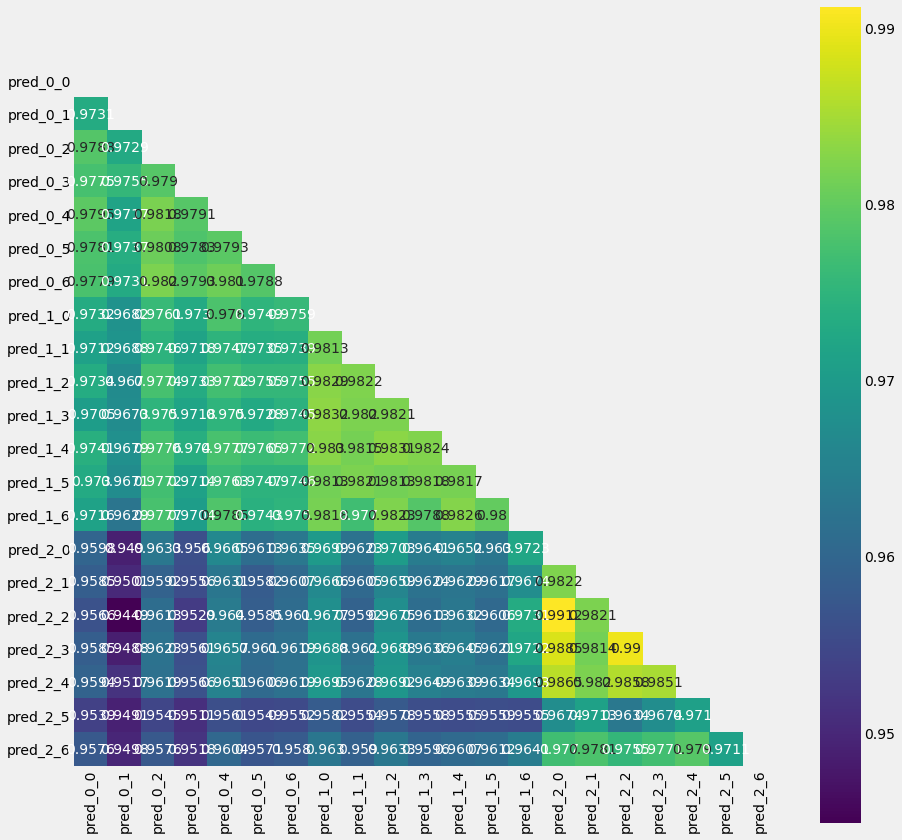

In [78]:
# Посмотрим корреялцию предсказаний между собой
corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(14, 14))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [79]:
# Объеденим ООФ прогнозы  в один датафрейм
scores_train = pd.DataFrame()
scores_train['xgb'] = oof_preds_xgb
scores_train['lgbm'] = oof_preds_lgbm
scores_train['cat'] = oof_preds_cat

In [80]:
# Обучим ЛогРегрессию на трейне
log = LogisticRegression()
log.fit(scores_train, target)

LogisticRegression()

In [81]:
# ПРименим логРегрессию к тестовым прогнозам, но сначало усредним прогнозы каждой модели
submission['xgb'] = gmean(scores[[col for col in scores.columns if col.startswith("pred_0")]], axis=1)
submission['lgbm'] = gmean(scores[[col for col in scores.columns if col.startswith("pred_1")]], axis=1)
submission['cat'] = gmean(scores[[col for col in scores.columns if col.startswith("pred_2")]], axis=1)

In [82]:
submission.shape

(165141, 5)

In [83]:
# Получим прогнозы для теста
submission['sumbit_logreg'] = log.predict_proba(submission[['xgb', 'lgbm', 'cat']])[:, 1]
submission[['application_number', 'sumbit_logreg']].\
            rename(columns={'application_number':'APPLICATION_NUMBER','sumbit_logreg':'TARGET'}).\
            to_csv(f'out/sumbit_logreg_iter_{ITER_VER}.csv', index = False)